__Project:__ Intent Recognition <br> 
__Sub-prj:__ Parametric Evaluation - _number of labels & data fraction_ <br>
__Experm:__ Distilbert-base-uncased <br>
__Status:__ Version 2.0 <br>
    - Added custom callback function for tracking f1-score <br>
__Contact:__ Amir Hossini <br>
__Dev Dat:__ Oct 21, 2021 <br>

#### Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import Callback
import sklearn
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score 
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

print(f"Tensorflow version: {tf.__version__}")
print(f"Sklearn version: {sklearn.__version__}")
print(f"Transformers version: {transformers.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.5.0
Sklearn version: 1.0
Transformers version: 4.11.3
Num GPUs Available:  1


#### I/O Files & Params

In [7]:
fl_train = '../datasets/banking77/train.csv'
fl_test  = '../datasets/banking77/test.csv'

# experiment_grid = {
#     'n_labels'  : [2, 5, 10, 20],
#     'train_frac': [0.1, 0.5, 1.0]
# }

experiment_grid = {
    'n_labels'  : [10],
    'train_frac': [0.05]
}

seed = 42

#### Functions

In [8]:
class Metrics(Callback):
    def __init__(self, validation_data):
        super(Metrics, self).__init__()
        self.validation_data = validation_data
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.argmax(tf.nn.softmax(self.model.predict(self.validation_data[0]).logits),1)
        val_targ = self.validation_data[1]
        val_f1 = f1_score(val_targ, val_predict, average='macro')
        val_recall = recall_score(val_targ, val_predict, average='macro')
        val_precision = precision_score(val_targ, val_predict, average='macro')
        logs['val_f1'] = val_f1
        logs['val_recall'] = val_recall
        logs['val_precision'] = val_precision
        print (f'— val_f1: {round(val_f1,4)} — val_precision: {round(val_precision,4)} — val_recall: {round(val_recall,4)}')
        return

def select_data(train, test, col_label, n_labels=None, train_frac=None):
    if n_labels is None:
        n_labels = len(train.loc[:,col_label].unique())
    if train_frac is None:
        train_frac = 1
        
    select_labels = np.array(train.loc[:,col_label].value_counts()[0:n_labels].index)
    select_train  = train.loc[train[col_label].isin(select_labels),:].reset_index(drop=True)
    n_data_train  = len(select_train)
    n_data_select = int(n_data_train * train_frac)
    indx_select   = np.random.choice(range(n_data_train),n_data_select)
    select_train  = select_train.iloc[indx_select,:]
    select_train  = select_train.reset_index(drop=True)
    select_test   = test.loc[test[col_label].isin(select_labels),:].reset_index(drop=True)
    n_data_test   = len(select_test)
    indx_test     = np.random.choice(range(n_data_test),n_data_test)
    select_test   = select_test.iloc[indx_test,:]
    select_test   = select_test.reset_index(drop=True)
    return select_train, select_test

def factorize_data(train, test, col_label,return_keys=False):
    train_labels, levels = pd.factorize(train.loc[:,col_label])
    categs = pd.concat([train.loc[:,col_label],pd.Series(train_labels)],axis=1).groupby(col_label).mean().index
    labels = pd.concat([train.loc[:,col_label],pd.Series(train_labels)],axis=1).groupby(col_label).mean().values.T[0]
    label_keys=dict(zip(categs,labels))
    test_labels = test.loc[:,col_label].map(lambda x: label_keys[x])
    train.loc[:,col_label]=train_labels
    test.loc[:,col_label]=test_labels
    if return_keys:
        return train, test, label_keys
    else:
        return train, test
    
def tokenize_encode_data(train,test,col_text,col_label,checkpoint='distilbert-base-uncased',
                         truncation_flag=True, padding_flag=True, return_tensors_opt='np'):
    train_sentences = list(train.loc[:,col_text])
    test_sentences  = list(test.loc[:,col_text])
    train_labels    = list(train.loc[:,col_label])
    test_labels     = list(test.loc[:,col_label])
    tokenizer       = AutoTokenizer.from_pretrained(checkpoint)
    train_encodings = tokenizer(train_sentences, truncation=truncation_flag,
                                padding=padding_flag, return_tensors=return_tensors_opt)
    test_encodings  = tokenizer(test_sentences, truncation=truncation_flag,
                                padding=padding_flag, return_tensors=return_tensors_opt)
    return train_encodings.data, train_labels, test_encodings.data, test_labels 

def transformer_model(train_encodings, train_labels, test_encodings, test_labels, 
                      n_labels,verbose=3,lr=5e-5, epochs=10,batch_size=64,
                      checkpoint='distilbert-base-uncased'):
    model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=n_labels)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    history = model.fit(train_encodings,np.array(train_labels),epochs=epochs,batch_size=batch_size,
          validation_data=(test_encodings, np.array(test_labels)),callbacks=[Metrics(validation_data)])
    return history, model


Experiment 1 with 10 labels and sample fraction of 0.05

size of training dataset: 88
size of testing dataset: 400


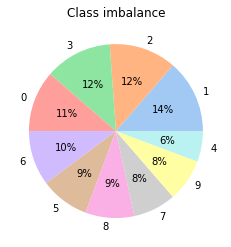

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/40
2/2 [==============================] - 7s 2s/step - loss: 2.2939 - accuracy: 0.1477 - val_loss: 2.2916 - val_accuracy: 0.1650
— val_f1: 0.0848 — val_precision: 0.1195 — val_recall: 0.1616
Epoch 2/40
2/2 [==============================] - 1s 937ms/step - loss: 2.2592 - accuracy: 0.2045 - val_loss: 2.2721 - val_accuracy: 0.2650
— val_f1: 0.2027 — val_precision: 0.2077 — val_recall: 0.2663
Epoch 3/40
2/2 [==============================] - 1s 945ms/step - loss: 2.2089 - accuracy: 0.3295 - val_loss: 2.2348 - val_accuracy: 0.3000
— val_f1: 0.2186 — val_precision: 0.1917 — val_recall: 0.3061
Epoch 4/40
2/2 [==============================] - 1s 965ms/step - loss: 2.1340 - accuracy: 0.5568 - val_loss: 2.1837 - val_accuracy: 0.3325
— val_f1: 0.2451 — val_precision: 0.2544 — val_recall: 0.332
Epoch 5/40
2/2 [==============================] - 1s 967ms/step - loss: 2.0651 - accuracy: 0.5114 - val_loss: 2.1198 - val_accuracy: 0.3575
— val_f1: 0.2675 — val_precision: 0.2754 — val_recall: 0

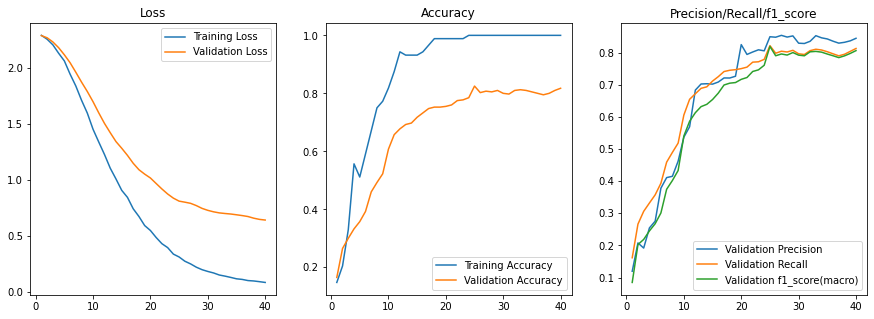

In [9]:
np.random.seed(seed)
train_orig = pd.read_csv(fl_train)
test_orig  = pd.read_csv(fl_test)

Big_Matrix      = pd.DataFrame(columns=['experiment','num_categ','sample_size','val_f1'])

iexp=0
for ilab in experiment_grid['n_labels']:
    for ifrac in experiment_grid['train_frac']:
        iexp+=1
        train, test = select_data(train_orig, test_orig, 'category', ilab, ifrac)
        train, test = factorize_data(train, test, 'category')
        print(f'\nExperiment {iexp} with {ilab} labels and sample fraction of {ifrac}')
        print(f'\nsize of training dataset: {len(train)}')
        print(f'size of testing dataset: {len(test)}')
        colors = sns.color_palette('pastel')[0:ilab]
        _ = plt.pie(list(train['category'].value_counts()), 
                    labels = list(train['category'].value_counts().index), 
                    colors = colors, autopct='%.0f%%')
        _ = plt.title('Class imbalance')
        _ = plt.show()
        
        train_encodings, train_labels, test_encodings, test_labels = tokenize_encode_data(train,test,'text','category',checkpoint='distilbert-base-uncased')
        validation_data=(test_encodings, np.array(test_labels))
        history, fitted_model = transformer_model(train_encodings, train_labels, test_encodings, test_labels,ilab,epochs=40)
        fig, axes   = plt.subplots(1,3,figsize=(15,5))
        epoch_range = np.arange(1,len(history.history['loss'])+1)
        axes[0]   = sns.lineplot(ax=axes[0],x=epoch_range,y=history.history['loss'],label='Training Loss')
        axes[0]   = sns.lineplot(ax=axes[0],x=epoch_range,y=history.history['val_loss'],label='Validation Loss').set_title('Loss')
        axes[1]   = sns.lineplot(ax=axes[1],x=epoch_range,y=history.history['accuracy'],label='Training Accuracy')
        axes[1]   = sns.lineplot(ax=axes[1],x=epoch_range,y=history.history['val_accuracy'],label='Validation Accuracy').set_title('Accuracy')
        axes[2]   = sns.lineplot(ax=axes[2],x=epoch_range,y=history.history['val_precision'],label='Validation Precision')
        axes[2]   = sns.lineplot(ax=axes[2],x=epoch_range,y=history.history['val_recall'],label='Validation Recall')
        axes[2]   = sns.lineplot(ax=axes[2],x=epoch_range,y=history.history['val_f1'],label='Validation f1_score(macro)').set_title('Precision/Recall/f1_score')
        axes[1].set_ylim=(0, 1)
        axes[2].set_ylim=(0, 1)
        _         = plt.show()
        
        Big_Matrix['experiment']   = iexp
        Big_Matrix['num_categ']    = ilab
        Big_Matrix['sample_size']  = ifrac
        Big_Matrix['val_f1'] = np.max(history.history['val_f1'])